In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image

from scipy.ndimage import binary_dilation, generate_binary_structure
from lips.detection import lipstick as ls

In [2]:
def display_image(image):
    plt.figure(figsize=(15, 15))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.imshow(image, 'gray')
    plt.show()
    #clear_output(wait=True)
    
    
    
image = cv2.imread("vera_test3.jpg")


new_image = ls(image, 1)

new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)


display_image(new_image)

from PIL import Image
im = Image.fromarray(new_image - image)
    
#     cv2.cvtColor(np.hstack([new_image, image]), cv2.COLOR_BGR2RGB))
im.save("vera_result4.jpeg")

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type


In [12]:

res = []
path = 'vera_video.mp4'

videoCapture = cv2.VideoCapture()
videoCapture.open(path)
fps = videoCapture.get(cv2.CAP_PROP_FPS) 
frames = videoCapture.get(cv2.CAP_PROP_FRAME_COUNT)
print("fps=", int(fps), "frames=", int(frames))
for i in range(int(frames)):
    ret, frame = videoCapture.read()
    res.append(ls(frame))
    cv2.imwrite("frames/%d.jpg"%(i), frame)

fps= 30 frames= 274


In [18]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 

video=cv2.VideoWriter('video_vera.mp4', fourcc, 1,(464,848))

for img in res:
    video.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

cv2.destroyAllWindows()
video.release()

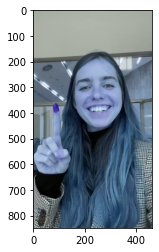

In [7]:
plt.imshow(frames)

In [16]:
def bounding_box(points, alpha=1.2):
    center = points.mean(axis=0)
    y, x = zip(*((points - center) * alpha + center))
    
    box = np.array([[min(x), min(y)], [max(x), max(y)]], dtype=int)
    
    return box

def build_slices(start, stop):
    """
    Returns a tuple of slices built from ``start`` and ``stop``.

    Examples
    --------
    >>> build_slices([1, 2, 3], [4, 5, 6])
    (slice(1, 4), slice(2, 5), slice(3, 6))
    >>> build_slices([10, 11])
    (slice(10), slice(11))
    """
    

    if stop is not None:
        return tuple(map(slice, start, stop))

    return tuple(map(slice, start))



def get_mask(shape, contours):
    mask = np.zeros(shape, np.uint8)

    return cv2.drawContours(mask, contours, -1, (1,), 1)




In [17]:
# определение текстуры губ с помощью brightness
def lipstick(image, alpha):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_face_mesh = mp.solutions.face_mesh
    mp_hands = mp.solutions.hands
    
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    
    with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
        image_clear = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_clear.flags.writeable = False
        results = face_mesh.process(image_clear)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.multi_face_landmarks:
            lipsUpperOuter = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291]
            lipsLowerOuter = [146, 91, 181, 84, 17, 314, 405, 321, 375, 291]
            lipsUpperInner = [78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308]
            lipsLowerInner = [78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308]
            

            lips_upper = lipsUpperOuter + lipsUpperInner[::-1]
            contours_upper = []

            for i in lips_upper:
                x =  int(results.multi_face_landmarks[0].landmark[i].x * image.shape[1])
                y =  int(results.multi_face_landmarks[0].landmark[i].y * image.shape[0])

                contours_upper.append([x, y])

            contours_upper = np.array(contours_upper)
            
            lips_lower = lipsLowerOuter + lipsLowerInner[::-1]
            contours_lower = []

            
            for i in lips_lower:
                x =  int(results.multi_face_landmarks[0].landmark[i].x * image.shape[1])
                y =  int(results.multi_face_landmarks[0].landmark[i].y * image.shape[0])

                contours_lower.append([x, y])

            contours_lower = np.array(contours_lower)
            
#             return contours_lower, contours_upper

            with mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

                results = hands.process(image_clear)

                if results.multi_hand_landmarks:
                    x = results.multi_hand_landmarks[0].landmark[8].x
                    y = results.multi_hand_landmarks[0].landmark[8].y
                    x = int(np.floor(image.shape[1]*x))
                    y = int(np.floor(image.shape[0]*y))

                    color = (image_clear[y, x, 2], image_clear[y, x, 1], image_clear[y, x, 0])
                    color = tuple(map(int, color))
                    bri = max(color[0], color[1], color[2])*100
                    
                    overlay = image.copy()
                    
                    cv2.fillPoly(overlay, pts =[contours_upper], color=color)
                    cv2.fillPoly(overlay, pts =[contours_lower], color=color)

                    
                    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)            

                    image_clear_hsv = cv2.cvtColor(image_clear, cv2.COLOR_BGR2HSV)
                    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                    mask = image_hsv[:,:,2] != image_clear_hsv[:,:,2]
                    mappa = image_clear_hsv[:,:,2]
                    mappa = np.float32(mappa)
                    mappa[mask] = (mappa[mask] - np.min(mappa[mask])) / (np.max(mappa[mask]) - np.min(mappa[mask]))
                    image_hsv[:,:,2][mask] = np.uint8(image_hsv[:,:,2][mask] * mappa[mask] * 1.2)
                    image = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)


                    image = np.array(image)
                    
                    
                    contours = [contours_upper, contours_lower]
                    mask = get_mask(image.shape[:2], contours)
                    box = bounding_box(np.concatenate(contours))

                    cropped_mask = mask[build_slices(*box)]
                    struct = np.ones((5, 5), dtype=bool)
                    dilated_mask = binary_dilation(cropped_mask, struct)

                    cropped_image = image[build_slices(*box)]
                    cropped_image = cv2.GaussianBlur(cropped_image, (5, 5), cv2.BORDER_DEFAULT)
                    image[build_slices(*box)][dilated_mask] = cropped_image[dilated_mask]


    return image

# cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

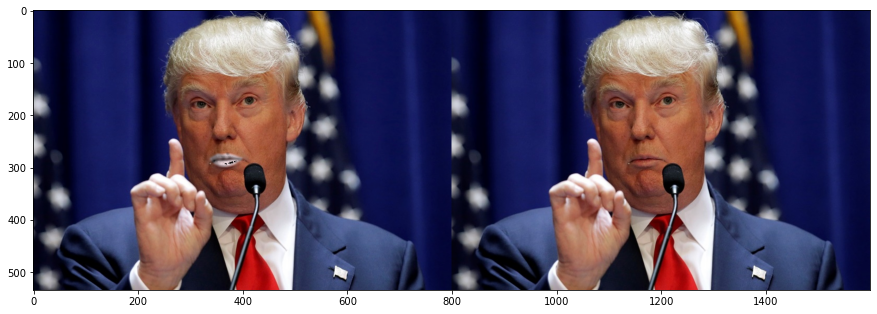

In [18]:
image = cv2.imread("JznXZlE.jpg")


new_image = lipstick(image, 1)


display_image(np.hstack([new_image, image]))

from PIL import Image
im = Image.fromarray(cv2.cvtColor(np.hstack([new_image, image]), cv2.COLOR_BGR2RGB))
im.save("vera_result4.jpeg")

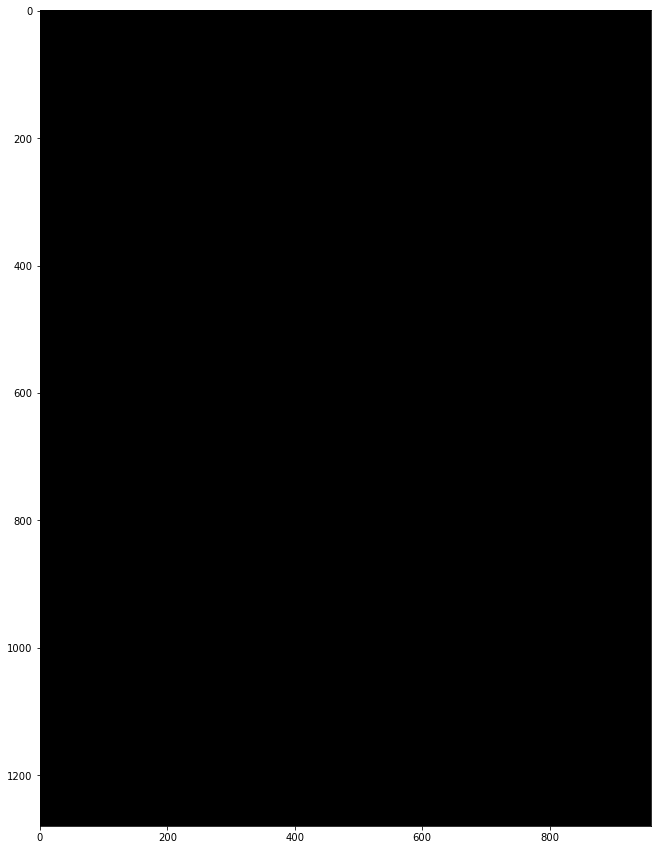

In [186]:
cnotours = lipstick(image, alpha)

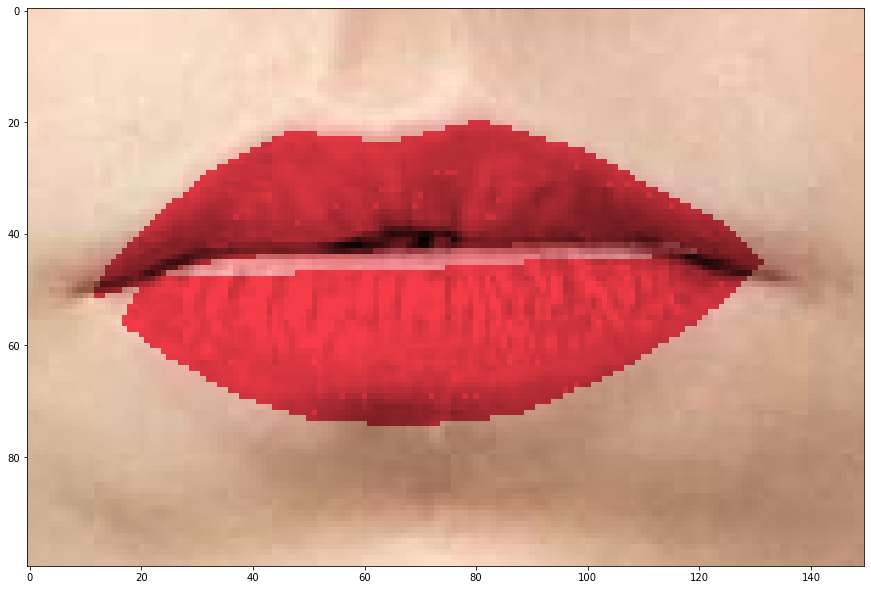

In [193]:
alphas = [1.0]
for alpha in alphas:
    new_image = lipstick(image, alpha)
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    display_image(new_image[600:700, 500:650])
    

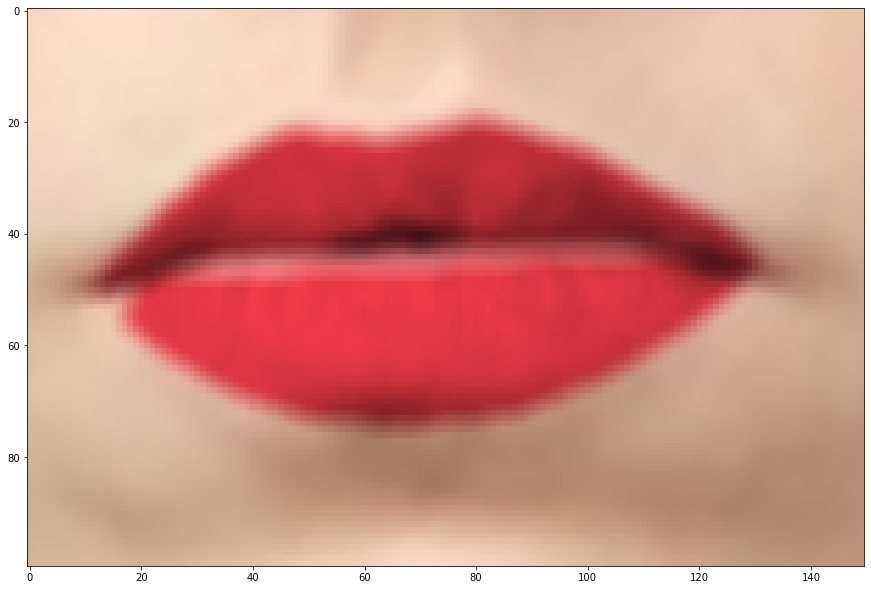

In [207]:
display_image(background[600:700, 500:650])

In [306]:
mask[600:700, 500:650].max()

255

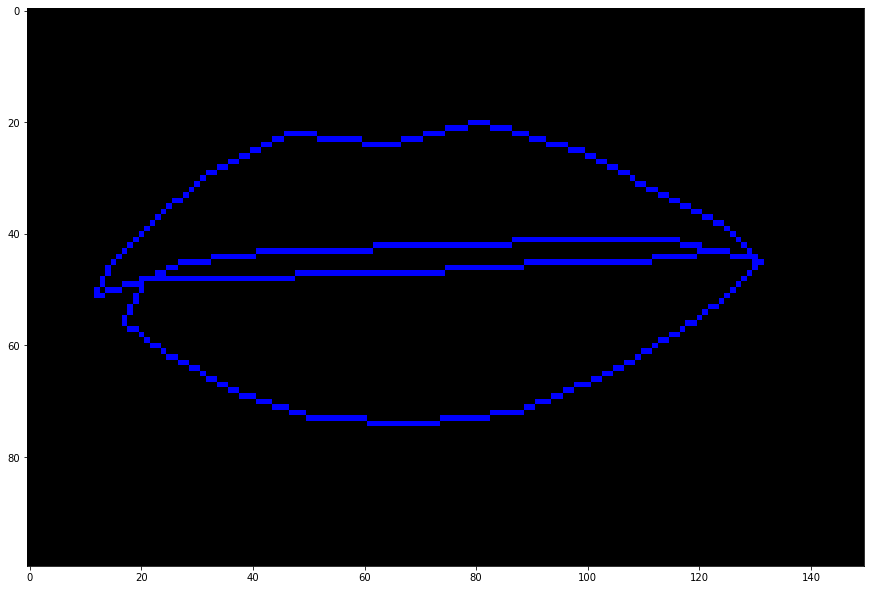

In [305]:
display_image(mask[600:700, 500:650])

In [63]:
left = image.shape[1] - new_image[..., 0].max() - 3
right = image.shape[1] - new_image[..., 0].min() + 3

up = new_image[..., 1].max() + 3
down = new_image[..., 1].min() - 3

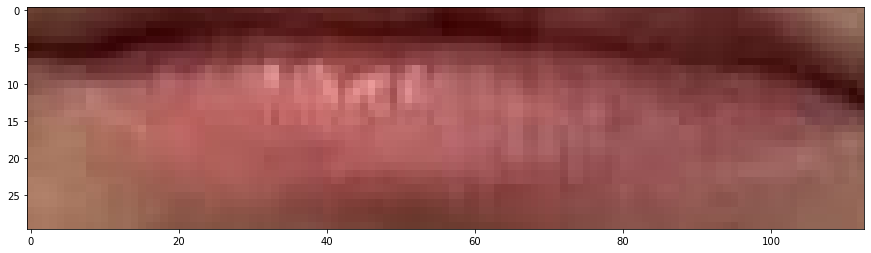

In [64]:
display_image(image[down:up,left:right, ...])

In [28]:
image[left: right, down: up, ...]

array([], shape=(0, 24, 3), dtype=uint8)

In [55]:
left, right

(454, 347)

In [34]:
image[left:right]

array([], shape=(0, 959, 3), dtype=uint8)

In [199]:
def overlay_image(foreground_image, background_image, foreground_mask):
    background_mask = cv2.cvtColor(255 - cv2.cvtColor(foreground_mask, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
    masked_fg = (foreground_image * (1 / 255.0)) * (foreground_mask * (1 / 255.0))
    masked_bg = (background_image * (1 / 255.0)) * (background_mask * (1 / 255.0))
    return np.uint8(cv2.addWeighted(masked_fg, 255.0, masked_bg, 255.0, 0.0))

In [319]:
mask = np.zeros(image.shape[:2], np.uint8)

mask =  cv2.drawContours(mask, contours, -1, (255),1)

blur = cv2.GaussianBlur(mask, (25,25),cv2.BORDER_DEFAULT)

background = cv2.GaussianBlur(new_image, (5, 5),cv2.BORDER_DEFAULT)

# blur = cv2.addWeighted(blur, 1, new_image, 1, 0)

display_image(np.hstack([new_image, overlay_image(new_image, background, blur)]))

# # cv2.drawContours(mask, new_image, -1, (255),1)
# cv2.addWeighted( blur, 1.5, img, -0.5, 0)

error: OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-r0utbq5z/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [320]:
binary_dilation(mask[build_slices(*box)]).shape

(65, 143)

In [340]:
struct = np.ones((7, 7), dtype=bool)

struct

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]])

In [7]:
from scipy.ndimage import binary_dilation, generate_binary_structure


In [353]:
cropped_new_image = np.array(new_image[build_slices(*box)])

struct = np.ones((5, 5), dtype=bool)
dilated_mask = binary_dilation(mask[build_slices(*box)], struct)

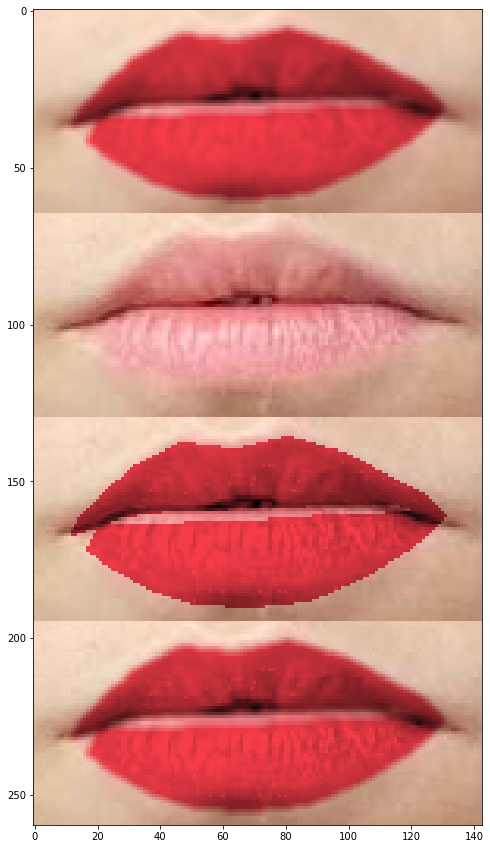

In [354]:
frame = cv2.GaussianBlur(new_image, (3, 3), cv2.BORDER_DEFAULT)

cropped_new_image[dilated_mask] = frame[build_slices(*box)][dilated_mask]

display_image(np.vstack([frame[build_slices(*box)], 
                         image[build_slices(*box)], 
                         new_image[build_slices(*box)], 
                         cropped_new_image]))

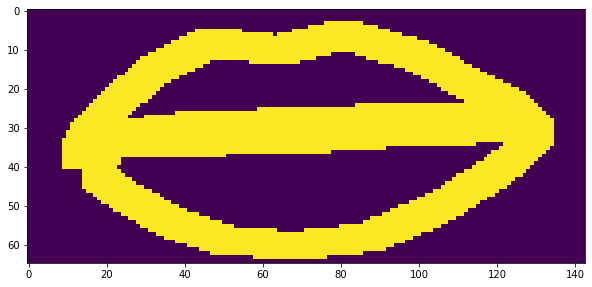

In [341]:
plt.figure(figsize=(10, 10))
plt.imshow(binary_dilation(mask[build_slices(*box)], struct))

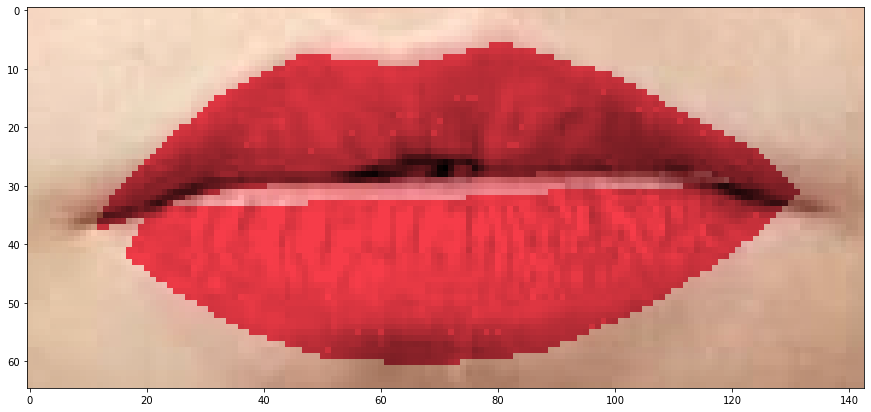

In [287]:
display_image(new_image[build_slices(*box)])

In [229]:
contours[0].mean(axis=0)

array([572.61904762, 653.85714286])

In [5]:
def bounding_box(points, alpha=1.2):
    center = points.mean(axis=0)
    y, x = zip(*((points - center) * alpha + center))
    
    box = np.array([[min(x), min(y)], [max(x), max(y)]], dtype=int)
    
    return box

def build_slices(start, stop):
    """
    Returns a tuple of slices built from ``start`` and ``stop``.

    Examples
    --------
    >>> build_slices([1, 2, 3], [4, 5, 6])
    (slice(1, 4), slice(2, 5), slice(3, 6))
    >>> build_slices([10, 11])
    (slice(10), slice(11))
    """
    

    if stop is not None:
        return tuple(map(slice, start, stop))

    return tuple(map(slice, start))



def get_mask(shape, contours):
    mask = np.zeros(shape, np.uint8)

    return cv2.drawContours(mask, contours, -1, (1,), 1)



In [286]:
box = bounding_box(np.concatenate([contours[0], contours[1]]))

In [246]:
list(map(func, [1, 2, 3], [4, 5, 6]))

[[4, 1], [5, 2], [6, 3]]

In [244]:
func = lambda x, y: [y, x]

In [247]:
slice(10 ,20)

slice(10, 20, None)

In [274]:
box

array([[640, 505],
       [678, 642]])